In [1]:
####################################################################################
'''
Importing Libraries

1. Scientific functions:

    a) numpy
    b) scipy
    c) JAX (GPU)

2. Plotting:

    a) matplotlib

3. Just-In-Time compilation : JAX
'''
####################################################################################

import scipy as sc
import torch as torch

import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn

import pathlib,json,os,time


import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm


jax.config.update('jax_enable_x64', True) # Set float-64 as a Default variable type.

In [2]:
####################################################################################
'''
Setting up and Mounting Google Drive for saving data
'''
####################################################################################

from google.colab import drive
drive.mount('/content/drive')
# Define path to your folder in Google Drive
folder_path = '/content/drive/MyDrive/2D_Burgers_stochastic'

# Create the folder if it does not exist
os.makedirs(folder_path, exist_ok=True)

Mounted at /content/drive


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 19 15:25:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# General Parameters

In [4]:
####################################################################################
'''
General definitions and set-up
'''
####################################################################################

pi = np.pi
N = 2**11 # No. of collocation points
L = 2*pi   # Domain length

dx = L/N

linear_array = jnp.linspace(0, L, N+1)[:-1]  # 1D mesh grid in real-space

mesh_grid = jnp.stack(jnp.meshgrid(linear_array, linear_array, indexing='ij')) # 2D meshgrid


dt = 1e-3           # step size
T_final = 40    #Final time

save_interval = 2   # frequency of saving data

steps = int(save_interval/dt)
T_final_steps = int(T_final/save_interval)

t = np.arange(0, T_final, save_interval)

nu = 3e-4  # Viscosity

####################################################################################
'''
Fourier Modes, Derivative operator And Cut-off for Spectral method
'''
####################################################################################

k_x = jnp.fft.fftfreq(N, d=L/N) * 2*pi
k_y = jnp.fft.rfftfreq(N, d=L/N) * 2*pi

k_vec = jnp.stack(jnp.meshgrid(k_x, k_y, indexing='ij'))                        # 2D Fourier-space Mesh-grid

derivative_operator = 1j * k_vec                                                # Derivative operator D = \iota \vec{k}

laplacian = -jnp.sum(k_vec**2, axis=0)                                          # \nabla^2 = -|k|^2

k_over_lapacian = jnp.where( laplacian == 0 , 0 , k_vec/(-1*laplacian) )        # \vec{k}/|k|^2. for the projection onto curl-free sector

k_UV_cutoff = N//4
UV_cutoff = (jnp.sqrt(-laplacian) <= k_UV_cutoff) * 1.0                         # UV-cutoff in Fourier space

alias_mask = (jnp.sqrt(-laplacian) <= N//3) * 1.0  # Dealias Mask



shells = jnp.arange(-0.5,N//2)
shells = shells.at[0].set(0)

####################################################################################
'''
Forcing in spectral space
'''
####################################################################################

beta = 2   # Power of covarianve of Forcing
D0 = 60     # Amplitude of the Forcing


force_amp_OU = D0*UV_cutoff*jnp.where(laplacian == 0, 0, jnp.sqrt(-laplacian)**(-beta/2)) # Total forcing amplitude with proper time-stepping multiplied for OU_process

force_amp = jnp.sqrt(dt)*D0*UV_cutoff*jnp.where(laplacian == 0, 0, jnp.sqrt(-laplacian)**(-beta/2)) # Total forcing amplitude with proper time-stepping multiplied.


# For Ornstien-Uhlembeck proces

theta = jnp.eye(2)            # Charecteristic time scales for both the components
sigma = jnp.eye(2)*0.05       # Covarianve Matrix for the forcing.


####################################################################################
'''
Initial Condition in spectral space
'''
####################################################################################
# We start with 0 inital condition for stochastic process or (sin(2x),sin(2y)) for the deterministic case.

u_0 = 0*jnp.stack((
    jnp.fft.rfft2(jnp.sin(2*mesh_grid[0]), norm='ortho'),
    jnp.fft.rfft2(jnp.sin(2*mesh_grid[1]), norm='ortho')))

# u_0 = jnp.load(os.path.join(folder_path, f'Velocity_field_{19}.npz'))['v_spec']

####################################################################################
'''
Semi-Group operators for IFRK4 method.
'''
####################################################################################

# Fixed linear operator calculation

linear_operator = nu * laplacian  # Laplacian is already negative

SemiG = jnp.exp(linear_operator * dt)
SemiG_Half = jnp.exp(linear_operator * dt / 2)

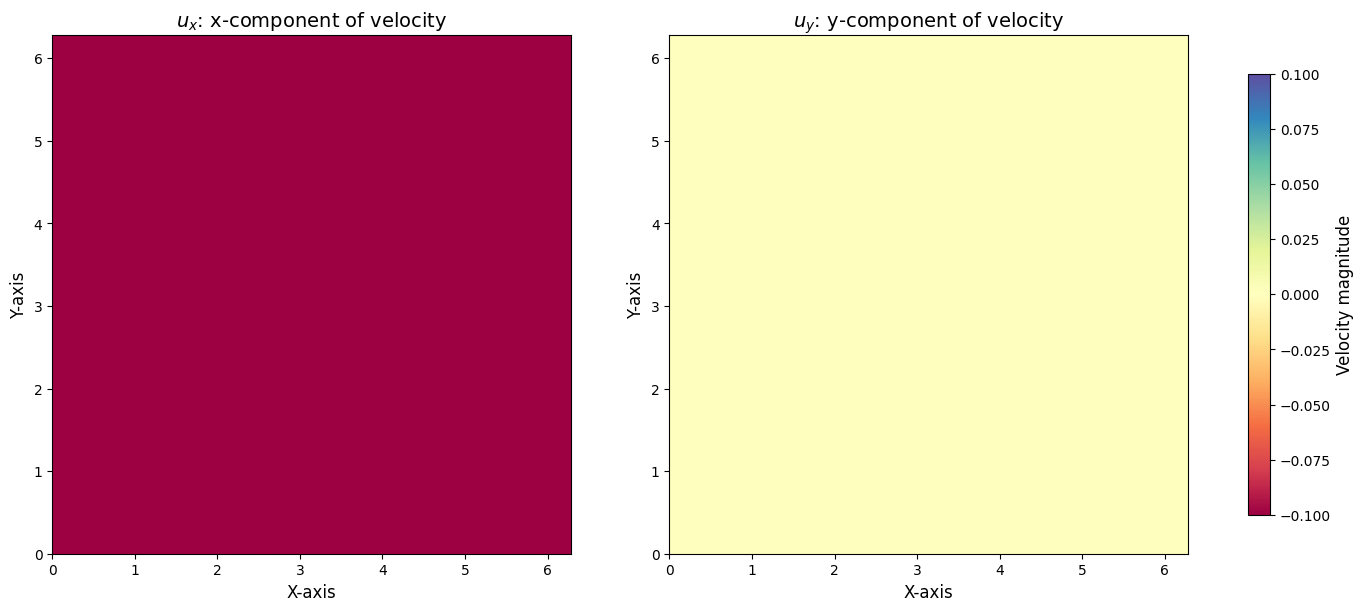

In [5]:
####################################################################################
'''
Visualization of initial condition
'''
####################################################################################

u_x = jnp.fft.irfft2(u_0[0], norm='ortho')
u_y = jnp.fft.irfft2(u_0[1], norm='ortho')

vmin = min(u_x.min(), u_y.min())
vmax = max(u_x.max(), u_y.max())

f, axarr = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

im0 = axarr[0].imshow(u_x, origin='lower', extent=[0, L, 0, L],
                      cmap='Spectral', vmin=vmin, vmax=vmax)
im1 = axarr[1].imshow(u_y, origin='lower', extent=[0, L, 0, L],
                      cmap='Spectral', vmin=vmin, vmax=vmax)

axarr[0].set_title(r'$u_x$: x-component of velocity', fontsize=14)
axarr[1].set_title(r'$u_y$: y-component of velocity', fontsize=14)

for ax in axarr:
    ax.set_xlabel("X-axis", fontsize=12)
    ax.set_ylabel("Y-axis", fontsize=12)

cbar = f.colorbar(im1, ax=axarr, shrink=0.85, location='right')
cbar.set_label("Velocity magnitude", fontsize=12)
plt.show()

In [6]:
####################################################################################
'''
Helping Function: 1.curl-free projection, 2.divergence  3.curl
'''
####################################################################################

@jax.jit
def curl_free_projection(u, k_over_lapacian = k_over_lapacian):

  return k_over_lapacian*(jnp.sum(k_vec*u, axis = 0))


@jax.jit
def divergence(u):

  return jnp.sum(derivative_operator*u,0)

@jax.jit
def curl(u):

  return jnp.fft.irfft2(derivative_operator[0]*u[1] - derivative_operator[1]*u[0] , norm = 'ortho')

# Forcing

In [7]:
####################################################################################
'''
Right-hand side computation for Burgers equation
'''
####################################################################################

@jax.jit
def computeRHS(U_spec, derivative_operator=derivative_operator, laplacian=laplacian, nu=nu):

    u = jnp.fft.irfft2(U_spec, axes=[1, 2], norm='ortho')

    u_squared = jnp.sum(u**2, axis=0)

    nonlinear_term = -0.5 * derivative_operator * jnp.fft.rfft2(u_squared, norm='ortho')

    return alias_mask*nonlinear_term   # + forcing_deterministic()

In [8]:
####################################################################################
'''
Defination for Stochastic Forcing
'''
####################################################################################


# OU-process
@jax.jit
def forcing_OU(forcing_field,noise , force_amp = force_amp_OU):

  forcing_field = jnp.reshape(forcing_field, (2,N**2))

  forcing_field = forcing_field - jnp.matmul(theta,forcing_field)*dt  + jnp.matmul(sigma,noise)*jnp.sqrt(dt)

  forcing_field = jnp.reshape(forcing_field, (2,N,N))

  spectral_forcing_field = force_amp*jnp.fft.rfft2(forcing_field, norm="ortho", axes=[1, 2])

  return  curl_free_projection(spectral_forcing_field) , forcing_field


@jax.jit
def forcing_deterministic():
  return jnp.stack((
    jnp.fft.rfft2(jnp.sin(2*mesh_grid[0]), norm='ortho'),
    jnp.fft.rfft2(jnp.sin(2*mesh_grid[1]), norm='ortho')))

In [9]:
####################################################################################
'''
IFRK-4 Method and loop for time evolution
'''
####################################################################################

@jax.jit
def IFRK4(u,forcing_field,key,sigma = sigma , theta = theta,dt=dt , N = N):

  key, subkey = jax.random.split(key)
  noise = jax.random.normal(subkey, (2, N, N))

  forcing_field = force_amp*jnp.fft.rfft2(noise, norm="ortho", axes=[1, 2])

  k1 = computeRHS(u)
  k2 = computeRHS(SemiG_Half * (u + 0.5 * dt * k1))
  k3 = computeRHS(SemiG_Half * u + 0.5 * dt * k2)
  k4 = computeRHS(SemiG * u + SemiG_Half * k3 * dt)

  return SemiG*u + (SemiG*k1 + 2*SemiG_Half*(k2 + k3) + k4)*(dt/6.0)  + curl_free_projection(forcing_field) ,forcing_field, key



def body_fun(i, state):

    u,forcing_field,key_repeator = state

    u_new,forcing_field ,key_repeator = IFRK4(u, forcing_field ,key_repeator)

    return u_new,forcing_field,key_repeator


@jax.jit
def repeator(u,forcing_field,skip,key_repeator, force_amp=force_amp):

    u ,forcing_field,key_repeator = jax.lax.fori_loop(0, skip, body_fun, (u,forcing_field,key_repeator))

    return u,forcing_field,key_repeator

In [10]:
####################################################################################
'''
Main-Body
'''
####################################################################################

seed = int(time.time_ns() % (2**32 - 1)) # initial seed for stochastic forcing
key_init = jax.random.key(seed)
force_field = jnp.zeros((2,N,N//2+1), dtype = 'complex128')


# Time evolution
for count in tqdm(range(T_final_steps+1)):

    print(u_0[0,2,3])

    u_0,force_field , key_init = repeator(u_0,force_field,steps,key_init)


    jnp.savez(os.path.join(folder_path, f'Velocity_field_{count}.npz'), v_spec = u_0)

  0%|          | 0/21 [00:00<?, ?it/s]

0j


  5%|▍         | 1/21 [00:31<10:33, 31.68s/it]

(-10.112085848823956+7.368895849492207j)


 10%|▉         | 2/21 [00:52<07:56, 25.10s/it]

(-7.228829626284731+1.1106149305315112j)


 14%|█▍        | 3/21 [01:12<06:52, 22.91s/it]

(0.9190859400921768+0.22652034795958648j)


 19%|█▉        | 4/21 [01:32<06:12, 21.89s/it]

(5.234415711973258+2.9167385889959707j)


 24%|██▍       | 5/21 [01:52<05:35, 20.97s/it]

(10.928663072685863-13.832884109467782j)


 29%|██▊       | 6/21 [02:11<05:05, 20.36s/it]

(-7.396074912736852-10.524069165896343j)


 33%|███▎      | 7/21 [02:30<04:38, 19.90s/it]

(-14.71971478128645-8.539711522501733j)


 38%|███▊      | 8/21 [02:49<04:16, 19.69s/it]

(0.6381789534765413-7.432207142419637j)


 43%|████▎     | 9/21 [03:08<03:55, 19.59s/it]

(28.574214311376878+6.226373343367643j)


 48%|████▊     | 10/21 [03:28<03:35, 19.56s/it]

(-14.646611707681325-5.281001002964208j)


 52%|█████▏    | 11/21 [03:47<03:14, 19.40s/it]

(10.605857794445136-21.2753790138199j)


 57%|█████▋    | 12/21 [04:06<02:53, 19.28s/it]

(-4.306957358831158-0.7422874485026187j)


 62%|██████▏   | 13/21 [04:25<02:34, 19.32s/it]

(8.158874768036258+13.092083272535023j)


 67%|██████▋   | 14/21 [04:44<02:14, 19.26s/it]

(3.8334016830119357-3.441706825757498j)


 71%|███████▏  | 15/21 [05:04<01:55, 19.25s/it]

(-10.504607860071955+15.307117479863924j)


 76%|███████▌  | 16/21 [05:23<01:35, 19.16s/it]

(-1.5420242006034537+2.8390339572000984j)


 81%|████████  | 17/21 [05:42<01:17, 19.32s/it]

(1.555244395671235+3.181933156816027j)


 86%|████████▌ | 18/21 [06:01<00:57, 19.24s/it]

(20.890196096122+23.671166511769133j)


 90%|█████████ | 19/21 [06:20<00:38, 19.09s/it]

(2.196767153531811+5.806127511266206j)


 95%|█████████▌| 20/21 [06:39<00:19, 19.16s/it]

(4.348188303135634-0.5477782306351332j)


100%|██████████| 21/21 [06:57<00:00, 19.89s/it]


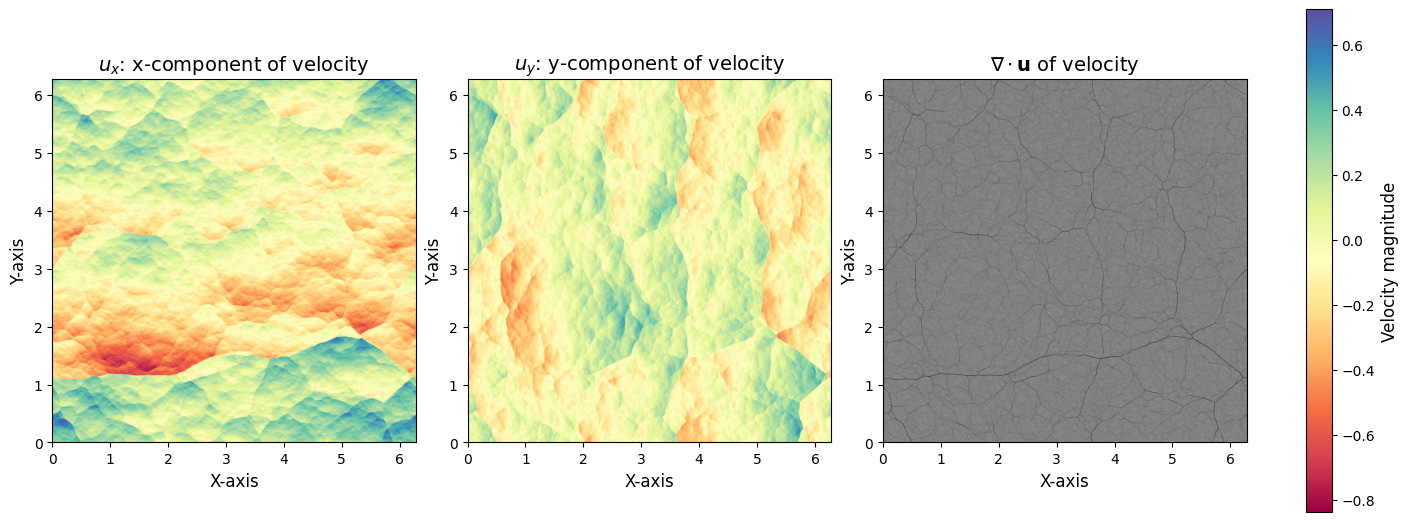

In [11]:
####################################################################################
'''
Visualization of Final condition
'''
####################################################################################

u_x = jnp.fft.irfft2(u_0[0], norm='ortho')
u_y = jnp.fft.irfft2(u_0[1], norm='ortho')

vmin = min(u_x.min(), u_y.min())
vmax = max(u_x.max(), u_y.max())

f, axarr = plt.subplots(1, 3, figsize=(14, 6), constrained_layout=True)

im0 = axarr[0].imshow(u_x, origin='lower', extent=[0, L, 0, L],
                      cmap='Spectral', vmin=vmin, vmax=vmax)
axarr[0].grid(False)

im1 = axarr[1].imshow(u_y, origin='lower', extent=[0, L, 0, L],
                      cmap='Spectral', vmin=vmin, vmax=vmax)

axarr[1].grid(False)

im2 = axarr[2].imshow( jnp.fft.irfft2(jnp.sum(derivative_operator*u_0,0)) , origin='lower', extent=[0, L, 0, L],cmap='gray', vmin= -0.05, vmax=0.05)

axarr[2].grid(False)

axarr[0].set_title(r'$u_x$: x-component of velocity', fontsize=14)
axarr[1].set_title(r'$u_y$: y-component of velocity', fontsize=14)
axarr[2].set_title(r'$\nabla \cdot \mathbf{u}$ of velocity', fontsize=14)

for ax in axarr:
    ax.set_xlabel("X-axis", fontsize=12)
    ax.set_ylabel("Y-axis", fontsize=12)

cbar = f.colorbar(im1, ax=axarr, shrink=0.85, location='right')
cbar.set_label("Velocity magnitude", fontsize=12)
plt.savefig('velocity_fields_div_fields')

plt.show()

In [12]:
####################################################################################
'''
Function calculating Energy Spectra
'''
####################################################################################

def Energy_spectra(x):
    return np.histogram(jnp.sqrt(-laplacian).ravel(),bins = shells,weights=x.ravel())[0]

In [13]:
####################################################################################
'''
calculating Averaged Energy Spectra for a given set of velocity field snapshots.
'''
####################################################################################

spectrum = jnp.zeros(len(shells)-1)

init = 15 # Initial snapshot number

final = 20  # Final snapshot number

for i in range(init, final ):

  u_dummy = jnp.load(os.path.join(folder_path, f'Velocity_field_{i}.npz'))['v_spec']

  spectrum += (1/N**2)*Energy_spectra(0.5*jnp.sum(jnp.abs(u_dummy)**2,0))

spectrum = spectrum/(final-init+1)       # Dividing by the proper factor

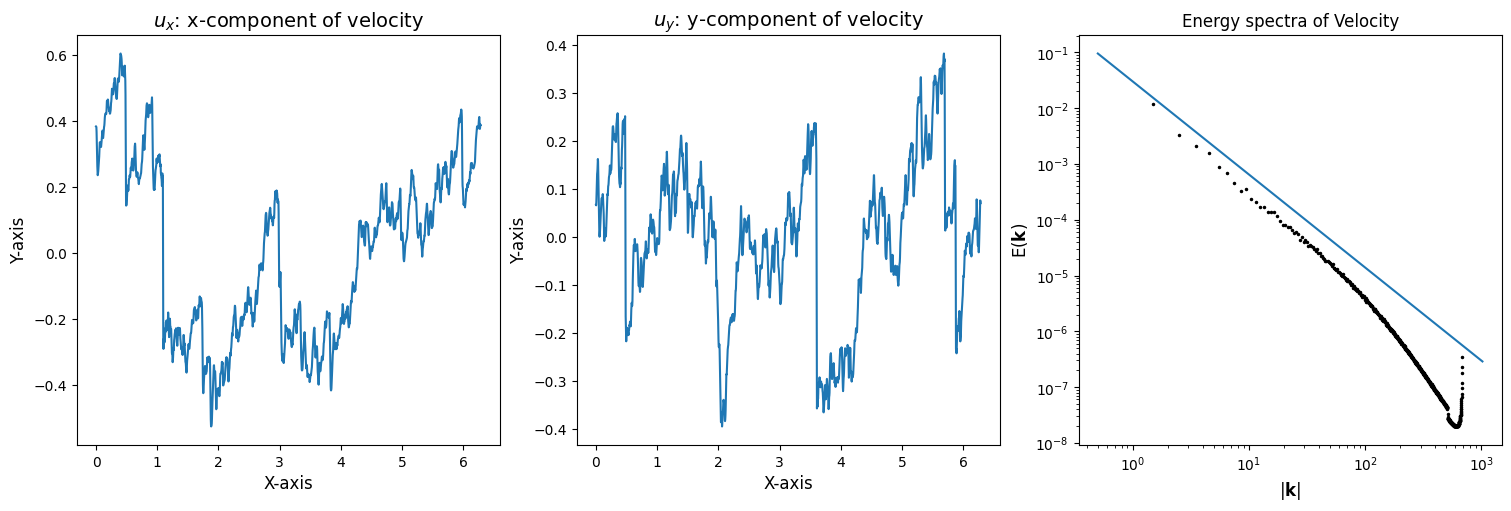

In [14]:
####################################################################################
'''
Visualization of Final condition And Energy Spectra
'''
####################################################################################

u_x = jnp.fft.irfft2(u_0[0], norm='ortho')
u_y = jnp.fft.irfft2(u_0[1], norm='ortho')



f, axarr = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)



im0 = axarr[0].plot(linear_array ,u_x[:,10])
im1 = axarr[1].plot(linear_array ,u_y[10,:])
im2 = axarr[2].loglog(shells[1:],spectrum ,'o', ms = 1.5 ,  color = 'black')
im2 = axarr[2].loglog(shells,3e-2*shells**(-5/3))

# axarr[2].set_ylim(8e-5,1e0)


axarr[0].set_title(r'$u_x$: x-component of velocity', fontsize=14)
axarr[1].set_title(r'$u_y$: y-component of velocity', fontsize=14)

for ax in axarr:
    ax.set_xlabel("X-axis", fontsize=12)
    ax.set_ylabel("Y-axis", fontsize=12)


axarr[2].set_xlabel(r"|$\mathbf{k}$|", fontsize=12)
axarr[2].set_ylabel(r"E($\mathbf{k}$)", fontsize=12)
axarr[2].set_title(r"Energy spectra of Velocity", fontsize=12)
cbar.set_label("Velocity magnitude", fontsize=12)


axarr[0].grid(False)
axarr[1].grid(False)
axarr[2].grid(False)

plt.savefig('cross_velocity_fields_Energy_spectra')

plt.show()

In [15]:
from google.colab import runtime
runtime.unassign()